# Quality Evaluation of Charge Curves 

In this notebook we will develop a quality value, a key performance indicator (KPI) that will allow us to determine the quality of a ChargePoint. The goal is to use this KPI to estimate or predict the charge duration, if the Chargepoint is borken, among other things.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Determination-of-the-Best-ChargePoint" data-toc-modified-id="Determination-of-the-Best-ChargePoint-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Determination of the Best ChargePoint</a></span><ul class="toc-item"><li><span><a href="#Implementation" data-toc-modified-id="Implementation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Implementation</a></span></li></ul></li><li><span><a href="#Quality-Evaluation" data-toc-modified-id="Quality-Evaluation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Quality Evaluation</a></span></li><li><span><a href="#Other-Vehicle-Manufacturers" data-toc-modified-id="Other-Vehicle-Manufacturers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Other Vehicle Manufacturers</a></span><ul class="toc-item"><li><span><a href="#Kia-eNiro" data-toc-modified-id="Kia-eNiro-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Kia eNiro</a></span></li><li><span><a href="#Tesla" data-toc-modified-id="Tesla-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Tesla</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime, sys, datetime, warnings
sys.path.append('../chargecurve/')
from databases import load_base2_ftp, query_station
from functions import get_peaks, collect_charges
from chargecurve import AutoCharge, ChargingCurve
from plot import charges, chargecurvestation, fullchargecurve
from sklearn.metrics import auc 

warnings.filterwarnings('ignore')

## Determination of the Best ChargePoint

For the determination of the best ChargePoint, we must first a statistical value, a metric, that allows us to quantify the charging event at the given ChargePoint. Once we have found this, then it will be possible to compare charging events between and charging curves among ChargePoints.

Possible metric that we can use are:

+ **Sum (Addition of all data points of a charging curve):** This metric will be neglected, since there are some charge curves with much more points than others. The more points one has to add, the bigger the final sum will be, hence, giving us little statistical meaningful information to compare.

+ **Maximum Charging Power**: This metric should also be avoided, since it is strongly affected by outlier points. If the largest charging power point is an outlier, then the KPI might be wrong.

+ **Average or Median Value:**  The median and mean values must be carefully evaluated, since mean values are also influenced by outliers. The median, on the other hand, is probably the safest metric to use, among these two.

+ **Integration (Area under the Curve)** This metric is little or basically unaffected by outliers and could be the best option for our purpose. However, to implement this metric, it is mandatory to have a complete charge curve, in order to compare with other curves. Otherwise, comparison is not possible. 

### Implementation

For the estimation of the above mentioned metrics, we will use the data of charging curves (State of Charge -SoC-  vs. Carging Power) focusing on SoC range between 20% and 80%.

Let us now determine all these metrics for a Charging curve of a ChargingPoint with 50kW charging power.

In this example we will analyze charging curves of a Hyundai Ioniq.

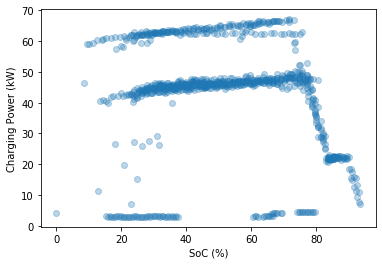

In [2]:
#load hyundai data
hyundai = load_base2_ftp('ecu_bcddc2d07024')
hyundai = hyundai[hyundai.model == 'HYUNDAIIONIQ']

#select while charging data, for Hyundai the conditions are as below
mask = (hyundai.hvBatteryCurrent < 0) & (hyundai.rpmEmotor <=0) \
& (hyundai.timestamp > datetime.datetime(2019,12,1)) 

#find peaks to extract charging curves
peaks_id = get_peaks(hyundai[mask], 'hvSocActualDisplay')

hyundai_charges = collect_charges(hyundai[mask], peaks_id)
#plot all charging curves
#chargecurvestation(hyundai_charges)

# instantiate the ChargingCurve object
HyundaiChargeCurve = ChargingCurve(hyundai_charges)

#plot the complete Charging Curve for this Auto
HyundaiChargeCurve.plotCurve()

In [3]:
#Define functions to estimate the metrics and plot them for comparison
def sorting(chargecurve,mask):
    
    chargepoints = chargecurve.data[mask].chargepoint_id.unique()

    #extract some  metrics
    df = pd.DataFrame({'chargePoint': [cp for cp in chargepoints],
                      'kw': [chargecurve.ChargePointCurve(cp).chargepoint_kw[mask].unique()[0]
                             if len(chargecurve.ChargePointCurve(cp).chargepoint_kw[mask].unique()) !=0
                             else np.nan for cp in chargepoints],
                       'sum': [chargecurve.ChargePointCurve(cp).power[mask].sum()
                               for cp in chargepoints],
                       'maxPower': [chargecurve.ChargePointCurve(cp).power[mask].max()
                                    for cp in chargepoints],
                       'meanPower': [chargecurve.ChargePointCurve(cp).power[mask].mean()
                                     for cp in chargepoints],
                       'medianPower': [chargecurve.ChargePointCurve(cp).power[mask].median()
                                       for cp in chargepoints],
                       'IntegralPower': [auc(chargecurve.ChargePointCurve(cp).soc_display[mask].values,
                                             chargecurve.ChargePointCurve(cp).power[mask].values)
                                         if pd.notna(cp) else np.nan for cp in chargepoints]
                      })
    return df

def plot_sorting(chargecurve,mask):
    
    sort_condions = ['maxPower', 'meanPower', 'medianPower', 'IntegralPower']

    fig = plt.figure(figsize=(15,10))
    for i, cond in enumerate(sort_condions):
        ax = fig.add_subplot(2,2,i+1)
        res = sorting(chargecurve,mask)
        res_sorted = res.sort_values(by=cond, ascending=False)
        res_sorted = res_sorted.chargePoint[:5]
        for n, cp in enumerate(res_sorted):
            ax.plot(chargecurve.ChargePointCurve(cp).soc_display[mask],
                    chargecurve.ChargePointCurve(cp).power[mask], '.-', 
                    label = '{}: {}'.format(n+1,cp), 
                    c='C{}'.format(res_sorted.index.values[n]))
            plt.title(cond)
            plt.legend()
            plt.xlabel('Soc [%]')
            plt.ylabel('Charging Power [kW]')
            plt.tight_layout()

Below is table with all the metrics (KPIs) determined for several charge curves of the Ioniq at a different 50kW chargePoints. Also, below, the corresponding curves, plotted in the SoC range between 205 and 80%, data at which the metric values are calculated. 

Each plot shows the sorted charge curve for a given metric. Lets look, for instance, at the plot in the upper left corner. This plot shows the maximal charging Power metric. Using this metric, ChargePoint 103952 has the 1st place (best), whereas Charge Point 95195 is placed in the 5th place.

In [4]:
# define a mask where we consider the curve only for the SoC range between 20% and 80% 
# and charger power of 50kW
mask = (HyundaiChargeCurve.data.soc_display > 20) \
        & (HyundaiChargeCurve.data.soc_display < 80) \
        & (HyundaiChargeCurve.data.chargepoint_kw == 50)

res = sorting(HyundaiChargeCurve,mask)
res

chargePoint    kw          sum   maxPower  meanPower  medianPower  \
0      95195.0  50.0  3003.177882  48.117919  44.823550    44.884101   
1      83102.0  50.0  2755.449731  48.679051  45.171307    45.361999   
2     102112.0  50.0  2448.218413  48.873301  46.192800    46.587502   
3     103086.0  50.0  2489.257664  47.704770  45.259230    45.668319   
4     101149.0  50.0  2670.548441  48.885124  45.263533    45.983199   
5     103952.0  50.0  2239.361810  48.892063  45.701261    46.338601   

   IntegralPower  
0    2653.939083  
1    2664.588308  
2    2436.773973  
3    2470.573282  
4    1440.465900  
5    2220.594271

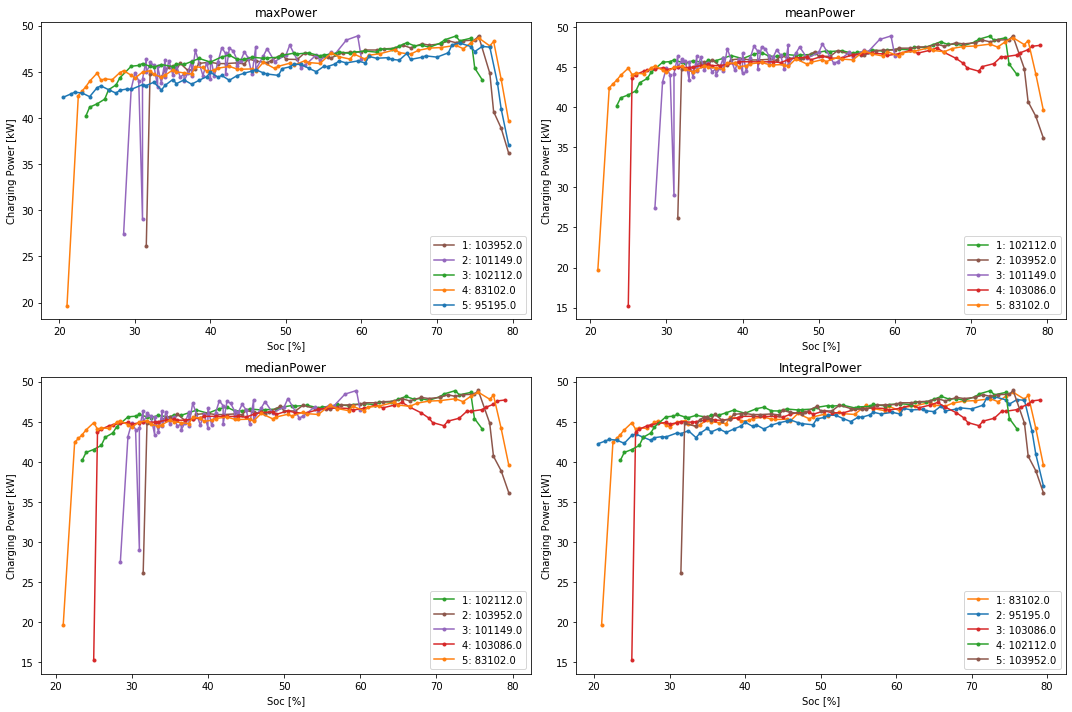

In [5]:
plot_sorting(HyundaiChargeCurve,mask)            

By having a closer look of the 50kW curves, when using the Median/mean method, Charge Point (CP) 102112 (green curve) gets the 1st place whereas CP 83102 (orange) gets place 5. The orange curve, has the best performance at SoC below ~30% and also maintains a high Power at SoC larger than 75% in comparison with the others. This behavior is captured by the integration method which places the orange curve in the first place, and puts CP 102112 (green) in place 4. Notice that although, the orange curve has a slightly lower overall charging power (about 1kW) compared to the green curve, it maintains the high power a larger SoC range as the green one, thus making it the best curve.

Although, from the figures, we can see that not all CPs have a full charging curve, which means that we can not fully, or better, fairly compare them. More data is required to finally judge this metric.

Let us now check 350 kW CPs curves.

In [6]:
mask = (HyundaiChargeCurve.data.soc_display > 20) \
        & (HyundaiChargeCurve.data.soc_display < 80) \
        & (HyundaiChargeCurve.data.chargepoint_kw == 350)

res = sorting(HyundaiChargeCurve,mask)
res_sorted = res.sort_values(by='IntegralPower', ascending=False) 
res_sorted

chargePoint     kw          sum   maxPower  meanPower  medianPower  \
1     101322.0  350.0  2882.287380  66.850698  60.047654    63.129576   
2     101226.0  350.0  2376.368106  67.093620  64.226165    64.069316   
0     125383.0  350.0   308.464653  61.977798  61.692931    61.796702   

   IntegralPower  
1    3510.767753  
2    3033.539377  
0     308.427924

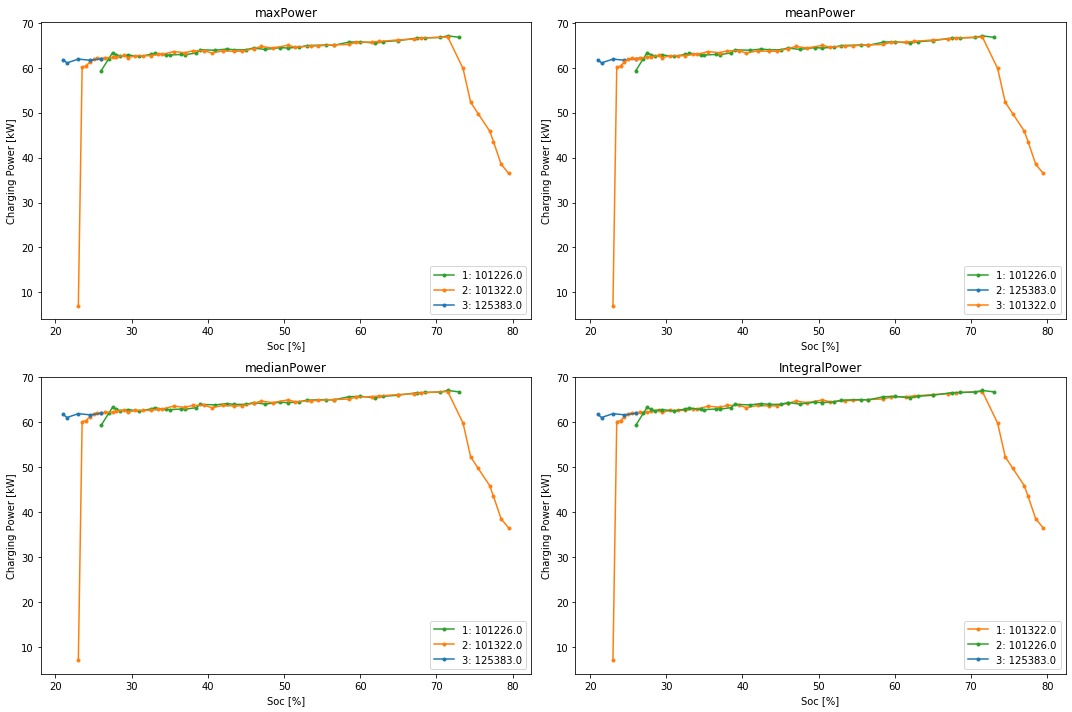

In [7]:
plot_sorting(HyundaiChargeCurve,mask)

Once again, the lack of completeness data does not allow a fair comparison of these metrics. Note, however, that the integration metric place CP 101322 (orange) in the first place (best), although, the other metrics don't. THis is because the orange curve has more data at SoC larger than 75%. This data is integrated and adds to the integration KPI value. For the median/mean metrics, the data above 75%, actually reduces the metric value and hence, makes the orange curve to be evaluated worstly as the other curves. This is due, as mentioned already, due to the lack of data.

## Quality Evaluation

We can now attribute a quality factor (KPI) to a CP, that allows us to compare its performance with respect to other CPs based on their charging curves. 

This Q score will be calculated as follows:


$$Q = \frac{\alpha_i}{\alpha_{max}}$$

where

$\alpha_i$: Metric of the Charging curve at a given CP

$\alpha_{max}$: Highest metric value among CPs with the same charging Power.

This procedure is implemented as a method of the ChargingCurve Class, and produces a table with the different metrics and their corresponding Q values ('chargePoint_quality').  

Below is an example of this table.

In [8]:
HyundaiChargeCurve.getChargePointQuality(method='mean')

chargePoint  meanPower  medianPower  IntegralPower  chargePoint_quality  \
1     106334.0   4.102356     4.073440      14.386145             1.000000   
0      91058.0   3.128499     3.166240       9.414832             0.762610   
2     101226.0  64.226165    64.069316    3033.539377             1.000000   
0     125383.0  61.692931    61.796702     308.427924             0.960558   
1     101322.0  60.047654    63.129576    3510.767753             0.934941   
2     102112.0  46.192800    46.587502    2436.773973             1.000000   
5     103952.0  45.701261    46.338601    2220.594271             0.989359   
4     101149.0  45.263533    45.983199    1440.465900             0.979883   
3     103086.0  45.259230    45.668319    2470.573282             0.979790   
1      83102.0  45.171307    45.361999    2664.588308             0.977886   
0      95195.0  44.823550    44.884101    2653.939083             0.970358   
0      28547.0   2.995614     3.009330     123.341685             1.000000   
0     124683.0  63.553425    63.450088    2939.768013             1.000000   
0     106765.0  61.174816    62.520992    3171.624130             1.000000   

   chargePoint_quality_int  chargePoint_power  
1                 1.000000               22.0  
0                 0.654437               22.0  
2                 0.864067              350.0  
0                 0.087852              350.0  
1                 1.000000              350.0  
2                 0.914503               50.0  
5                 0.833372               50.0  
4                 0.540596               50.0  
3                 0.927188               50.0  
1                 1.000000               50.0  
0                 0.996003               50.0  
0                 1.000000                3.7  
0                 1.000000               86.0  
0                 1.000000              160.0

## Other Vehicle Manufacturers 

Here we will analyze the charging data from other vehicle manufacturers

### Kia eNiro

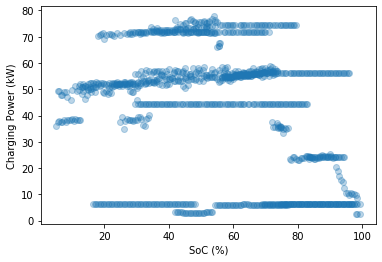

In [9]:
#load kia data
kia = load_base2_ftp('ecu_bcddc2d0718c')
kia = kia[kia.model == 'KIAENIRO']

#select while charging data, for kia the conditions are as below
mask = (kia.hvBatteryCurrent < 0) & (kia.rpmEmotor <=0) \
#& (kia.timestamp > datetime.datetime(2020,1,13)) \

#find peaks to extract charging curves
peaks_id = get_peaks(kia[mask], 'hvSocActualDisplay')

kia_charges = collect_charges(kia[mask], peaks_id)

# instantiate the ChargingCurve object
KiaChargeCurve = ChargingCurve(kia_charges)

#plot the complete Charging Curve for this Auto
KiaChargeCurve.plotCurve()

In [10]:
KiaChargeCurve.getChargePointQuality()

chargePoint  meanPower  medianPower  IntegralPower  chargePoint_quality  \
3     102176.0  69.031644    71.654941    3565.810242             1.000000   
0     106735.0  55.282878    56.076136    2773.988167             0.782586   
1     102135.0  56.977253    55.306671    3439.042907             0.771847   
2     102128.0  50.468941    54.071613    2461.295127             0.754611   
0     125383.0  65.171287    71.119176    3574.812126             1.000000   
0      99060.0  44.413316    44.393999    2220.574405             1.000000   
0       3425.0   3.121448     3.078800      35.866798             1.000000   

   chargePoint_quality_int  chargePoint_power  
3                 1.000000              150.0  
0                 0.777940              150.0  
1                 0.964449              150.0  
2                 0.690248              150.0  
0                 1.000000              350.0  
0                 1.000000               50.0  
0                 1.000000               11.0

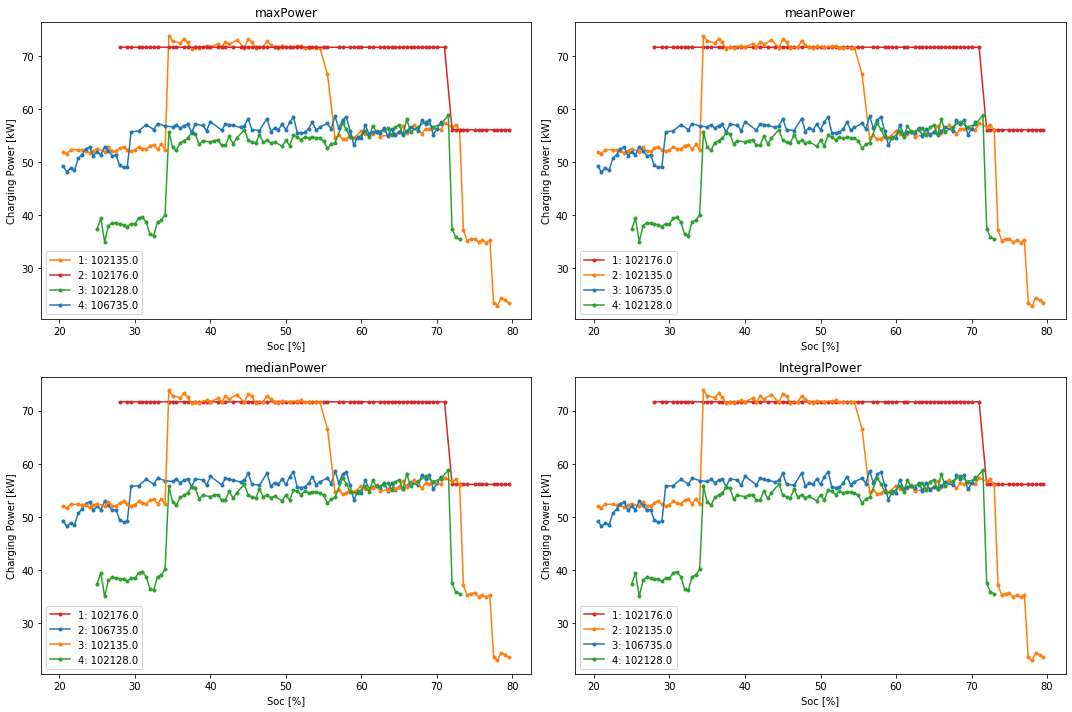

In [11]:
mask = (KiaChargeCurve.data.soc_display > 20) \
        & (KiaChargeCurve.data.soc_display < 80) \
        & (KiaChargeCurve.data.chargepoint_kw == 150)

plot_sorting(KiaChargeCurve,mask)

The figure above shows the sorted curves after evaluated with the discussed metrics. All methods have correctly selected the red curve as the best (CP 102176).

Among the other curves, the orange (CP 102135) is the one that should be placed as second, although, only the mean and integral method have evaluated the curve correctly.

### Tesla

For the Tesla data there is not enough data available, nevertheless, we show here the comparison of the methods for CPs with 50kW charging power.

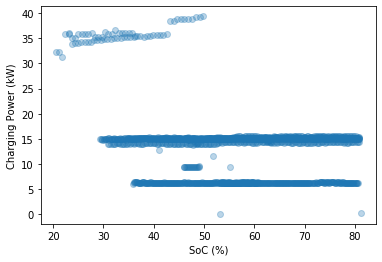

In [12]:
#load tesla data
tesla = load_base2_ftp('ecu_bcddc2ceb734')
tesla = tesla[tesla.model == 'TESLA_S']

#select while charging data, for Tesla the conditions are as below
mask = (tesla.hvBatteryCurrent > 0) & (tesla.rpmEmotor <=0) 

#find peaks to extract charging curves
peaks_id = get_peaks(tesla[mask], 'hvSocActualDisplay')

#collect all data for each charging curve at store it as AutoCharge() objects
tesla_charges = collect_charges(tesla[mask],peaks_id)

# instantiate the ChargingCurve object
TeslaChargeCurve = ChargingCurve(tesla_charges)

#plot the complete Charging Curve for this Auto
TeslaChargeCurve.plotCurve()

In [13]:
TeslaChargeCurve.getChargePointQuality()

chargePoint  meanPower  medianPower  IntegralPower  chargePoint_quality  \
0     105042.0  35.361537    35.935812     556.627661             1.000000   
1      83102.0  35.969550    35.334063     957.519057             0.983255   
2     103952.0  15.357879    15.469801     378.623598             0.430484   
0     103985.0  15.086046    15.092410     761.266132             1.000000   
1     102077.0  14.863846    14.883128      29.730591             0.986133   

   chargePoint_quality_int  chargePoint_power  
0                 0.581323               50.0  
1                 1.000000               50.0  
2                 0.395421               50.0  
0                 1.000000               22.0  
1                 0.039054               22.0

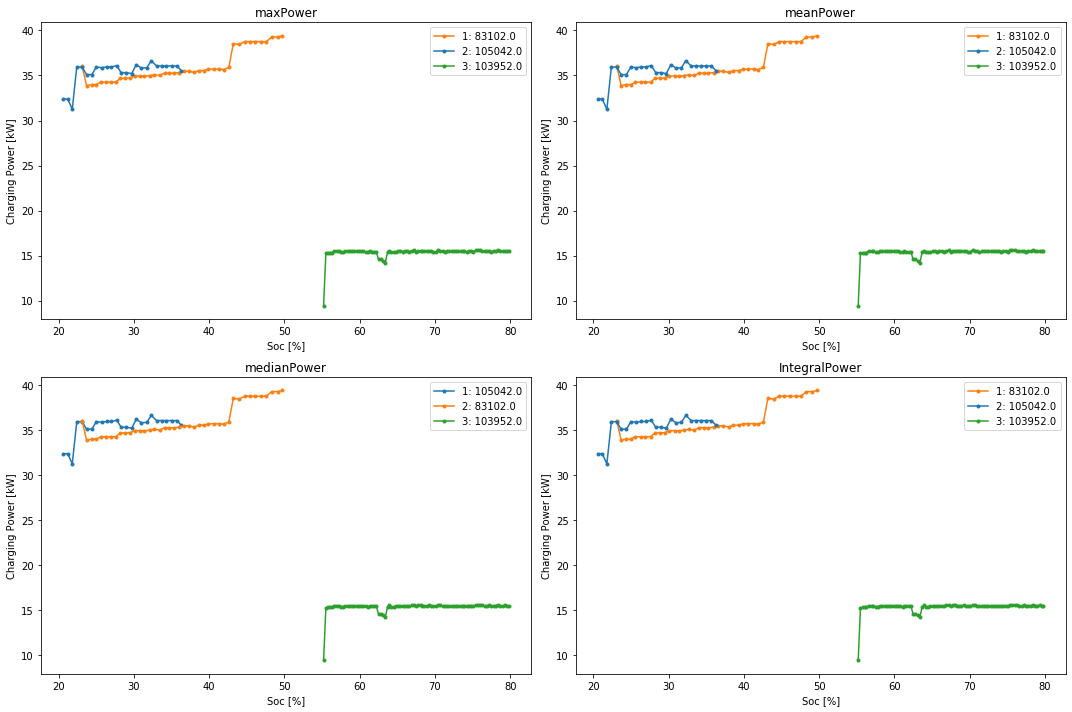

In [14]:
mask = (TeslaChargeCurve.data.soc_display > 20) \
        & (TeslaChargeCurve.data.soc_display < 80) \
        & (TeslaChargeCurve.data.chargepoint_kw == 50)

plot_sorting(TeslaChargeCurve,mask)

## Summary

We have implemented a quality evaluation procedure to estimate the performance of CPs based of charging curves data. To do this we have evaluated different metrics such as mean, median and area under the curve (integral).
All of these methods yield good results, although, each of them have limitations, for instance, the influence of outliers and data completeness.

More data is required, to perform a fair and proper evaluation of the different metrics. For the actual state, the median is probably the safest method to use due to its robustness. With full data completeness, will be the integration method the one to use.